In [1]:
#!/usr/bin/env python3

import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm

import logging
logging.basicConfig(level = logging.DEBUG, format = '%(asctime)s - %(levelname)s - %(message)s')

%run generalized_open

In [2]:
def pull_file_info(user_file):
    
    import re


    pressure_regex = re.compile(r'\d{2,}m{2}Hg')
    distance_regex = re.compile(r'(\d+\.\d)cm')
    gas_regex_notAir = re.compile(r'[A,a]rgon|[H,h]elium')
    
    pressure_match = pressure_regex.search(user_file)
    pressure_units = pressure_match.group()
    pressure = pressure_units.strip('mmHg')
    pressure = int(pressure)
    
    distance_match = distance_regex.search(user_file)
    distance = distance_match.group()
    
    gas_match = gas_regex_notAir.search(user_file)
    
    if gas_match == None:
        gas = 'Air'
    else:
        gas = gas_match.group()
    
    console_result = 'gas: %s \ndistance = %s \npressure = %s'%(gas, distance, pressure_units)
    
    print(console_result)
    
    return (gas, distance, pressure)


In [3]:
def calibration_curve(x):
    return x * 0.013863 + (-0.313343)


In [4]:
def particle_energy(user_dir, user_file):
    
    (gas, distance, pressure) = pull_file_info(user_file)
    
    raw_data = my_open(user_dir, user_file)
    
    #list of signal + noise counts
    count_data = raw_data[12:len(raw_data) - 1]

    #array of signal + noise counts recorded in data file
    signal_and_noise = np.array(count_data, dtype = int)
    
    #educated guess based on height of outermost peaks surrounding maxima
    threshold = 7
    
    signal = []
    
    #strip noise based on threshold
    for dataPoint in signal_and_noise:
        if dataPoint > threshold:
            signal.append(dataPoint)
        else:
            signal.append(0)
            
    signal = np.array(signal, dtype = int)
    
    #largest count recorded
    max_amplitude = np.amax(signal)
    
    #index of maxima 
    mean_adjustment = np.argmax(signal)
    
    #calculate the total number of counts
    count = np.sum(signal)
    
    #calculate mean and standard deviation of the counts
    mean, std_dev = norm.fit(signal)
    
    channel = mean + mean_adjustment
    
    pcl_energy = calibration_curve(channel)
    
    downstream_channel = channel + std_dev
    
    downstream_energy = calibration_curve(downstream_channel)
    
    pcl_energy_error = downstream_energy - pcl_energy 
    
    
    #print('particle energy:  %f (MeV)' %pcl_energy)
    #print('particle energy error:  %f (MeV)' %pcl_energy_error)
    
    
    #return (pcl_energy, pcl_energy_error, gas, distance, pressure)
    return (pcl_energy, pcl_energy_error, count, gas, distance, pressure)

In [5]:
#air data sets
air_height_spectra = os.path.abspath('height_spectra_air')

close_distance_energy = []
close_pressure = []
close_count = []

med_distance_energy = []
med_pressure = []
med_count = []

far_distance_energy = []
far_pressure = []
far_count = []

for root, dirs, files in os.walk(air_height_spectra):
    for dataSet in files:
        summary = particle_energy(air_height_spectra, dataSet)
        
        if summary[4] == '9.4cm':
            close_distance_energy.append(summary[0])
            close_pressure.append(summary[-1])
            close_count.append(summary[2])
            
        elif summary[4] == '11.4cm':
            med_distance_energy.append(summary[0])
            med_pressure.append(summary[-1])
            med_count.append(summary[2])
            
        else:
            far_distance_energy.append(summary[0])
            far_pressure.append(summary[-1])
            far_count.append([2])


assert len(far_distance_energy) == len(far_count)
assert len(med_distance_energy) == len(med_count)
assert len(close_distance_energy) == len(close_count)

print(close_pressure)
print(close_count)


2019-02-22 16:49:04,532 - DEBUG - file_path = /Users/nikourriola/Desktop/sp19/phys403/alpha/height_spectra_air/data_9.4cm_50mmHg.mca
2019-02-22 16:49:04,535 - DEBUG - file_path = /Users/nikourriola/Desktop/sp19/phys403/alpha/height_spectra_air/data_9.4cm_300mmHg.mca
2019-02-22 16:49:04,539 - DEBUG - file_path = /Users/nikourriola/Desktop/sp19/phys403/alpha/height_spectra_air/data_11.4cm_300mmHg.mca
2019-02-22 16:49:04,546 - DEBUG - file_path = /Users/nikourriola/Desktop/sp19/phys403/alpha/height_spectra_air/data_11.4cm_120mmHg.mca
2019-02-22 16:49:04,551 - DEBUG - file_path = /Users/nikourriola/Desktop/sp19/phys403/alpha/height_spectra_air/data_13.4cm_377mmHg.mca
2019-02-22 16:49:04,555 - DEBUG - file_path = /Users/nikourriola/Desktop/sp19/phys403/alpha/height_spectra_air/data_9.4cm_120mmHg.mca
2019-02-22 16:49:04,565 - DEBUG - file_path = /Users/nikourriola/Desktop/sp19/phys403/alpha/height_spectra_air/data_11.4cm_337mmHg.mca
2019-02-22 16:49:04,568 - DEBUG - file_path = /Users/nikour

gas: Air 
distance = 9.4cm 
pressure = 50mmHg
gas: Air 
distance = 9.4cm 
pressure = 300mmHg
gas: Air 
distance = 11.4cm 
pressure = 300mmHg
gas: Air 
distance = 11.4cm 
pressure = 120mmHg
gas: Air 
distance = 13.4cm 
pressure = 377mmHg
gas: Air 
distance = 9.4cm 
pressure = 120mmHg
gas: Air 
distance = 11.4cm 
pressure = 337mmHg
gas: Air 
distance = 9.4cm 
pressure = 260mmHg
gas: Air 
distance = 11.4cm 
pressure = 260mmHg
gas: Air 
distance = 9.4cm 
pressure = 337mmHg
gas: Air 
distance = 13.4cm 
pressure = 300mmHg
gas: Air 
distance = 11.4cm 
pressure = 377mmHg
gas: Air 
distance = 13.4cm 
pressure = 50mmHg
gas: Air 
distance = 9.4cm 
pressure = 220mmHg
gas: Air 
distance = 13.4cm 
pressure = 120mmHg
gas: Air 
distance = 9.4cm 
pressure = 377mmHg
gas: Air 
distance = 9.4cm 
pressure = 280mmHg
gas: Air 
distance = 13.4cm 
pressure = 260mmHg
gas: Air 
distance = 13.4cm 
pressure = 337mmHg
gas: Air 
distance = 11.4cm 
pressure = 50mmHg
[50, 300, 120, 260, 337, 220, 377, 280]
[316, 119, 

In [10]:
def eSquaredvP(pressure, energy, distance, xlabel, ylabel, title):
    
    import matplotlib.pyplot as plt
    
    squared_energy = []
    for dataPoint in energy:
        squared_energy.append(dataPoint**2)
    
    fig = plt.figure(num = 'Pressure %s' %pressure)
    ax = fig.add_axes([1,1,1,1])

    plt.plot(pressure, squared_energy, 'ko')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    
    
    plt.legend(['Air\nSource Dist. = %s'%distance], loc = 2)
    
    fig.savefig('eSquared %s'%pressure, bbox_inches = 'tight')
    
    plt.show()
    
    return

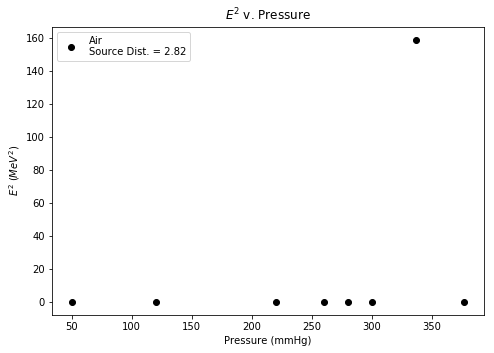

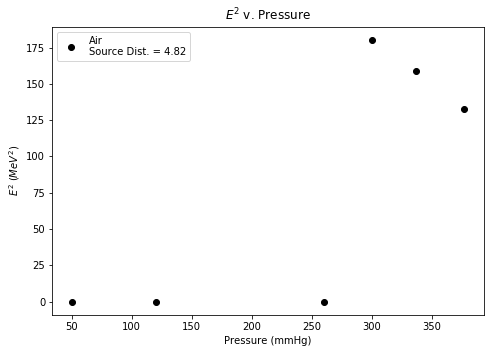

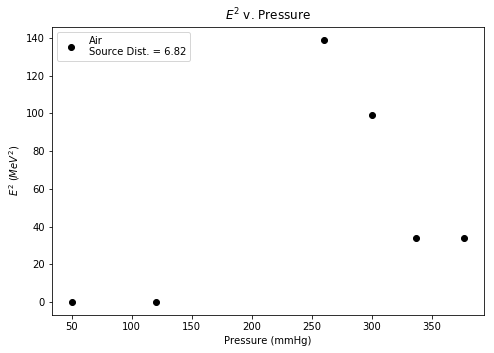

In [11]:
eSquaredvP(close_pressure, close_distance_energy, 2.82, 'Pressure (mmHg)', '$E^2$ ($MeV^2$)', '$E^2$ v. Pressure')
eSquaredvP(med_pressure, med_distance_energy, 4.82, 'Pressure (mmHg)', '$E^2$ ($MeV^2$)', '$E^2$ v. Pressure')
eSquaredvP(far_pressure, far_distance_energy, 6.82, 'Pressure (mmHg)', '$E^2$ ($MeV^2$)', '$E^2$ v. Pressure')


In [12]:
def calc_xEff(distance, pressure):
    import numpy as np
    
    pressure_array = np.asarray(pressure, dtype = int)
    
    #source to detector distance = scale reading - 6.58 + - 0.13cm
    true_distance = distance - 6.58
    
    #760 mmHg is atmospheric pressure
    xEff = (true_distance*pressure_array)/760
    
    return xEff

#9.4cm
xEff_close = calc_xEff(9.4, close_pressure)
print(xEff_close)

#11.4cm
xEff_med = calc_xEff(11.4, med_pressure)
print(xEff_med)

#13.4cm
xEff_far = calc_xEff(13.4, far_pressure)
print(xEff_far)


[0.18552632 1.11315789 0.44526316 0.96473684 1.25044737 0.81631579
 1.39886842 1.03894737]
[1.90263158 0.76105263 2.13728947 1.64894737 2.39097368 0.31710526]
[3.38307895 2.69210526 0.44868421 1.07684211 2.33315789 3.02413158]


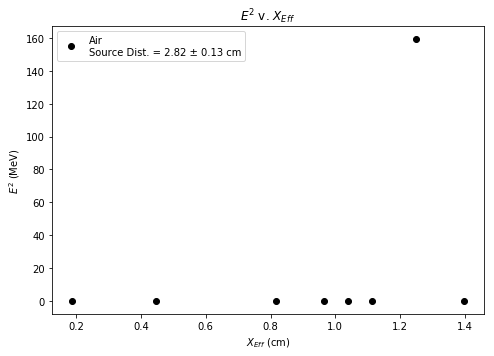

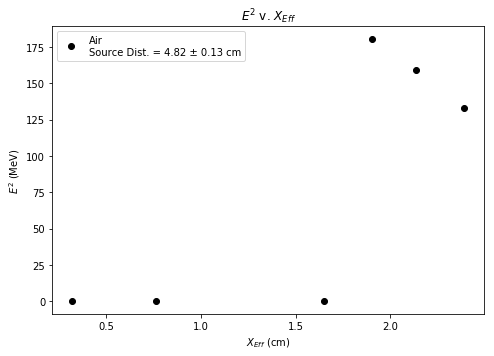

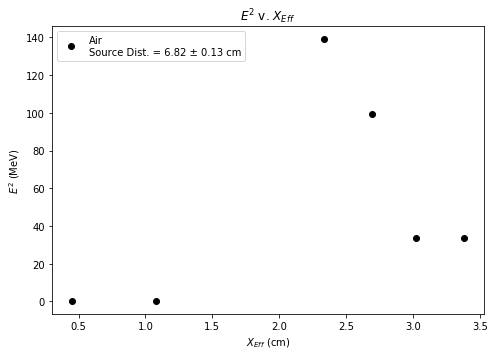

In [19]:
def eSquaredvxEff(xEff, energy, distance, xlabel, ylabel, title, name):
    
    import matplotlib.pyplot as plt
    
    squared_energy = []
    for dataPoint in energy:
        squared_energy.append(dataPoint**2)
    
    fig = plt.figure(num = 'X effective %s' %xEff)
    ax = fig.add_axes([1,1,1,1])
    
    plt.plot(xEff, squared_energy, 'ko')
    
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.legend(['Air\nSource Dist. = %s ± 0.13 cm'%distance])
    
    fig.savefig('eSquaredxEff %s'%name, bbox_inches = 'tight')
    
    plt.show()
    
    return 

close_xEff = calc_xEff(9.4, close_pressure)
med_xEff = calc_xEff(11.4, med_pressure)
far_xEff = calc_xEff(13.4, far_pressure)

eSquaredvxEff(close_xEff, close_distance_energy, 2.82, '$X_{Eff}$ (cm)', '$E^2$ (MeV)', '$E^2$ v. $X_{Eff}$', 'close')
eSquaredvxEff(med_xEff, med_distance_energy, 4.82, '$X_{Eff}$ (cm)', '$E^2$ (MeV)', '$E^2$ v. $X_{Eff}$', 'med')
eSquaredvxEff(far_xEff, far_distance_energy, 6.82, '$X_{Eff}$ (cm)', '$E^2$ (MeV)', '$E^2$ v. $X_{Eff}$', 'far')


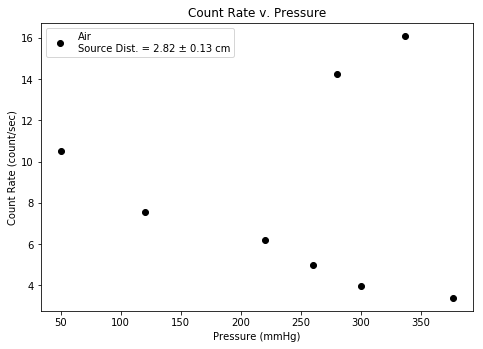

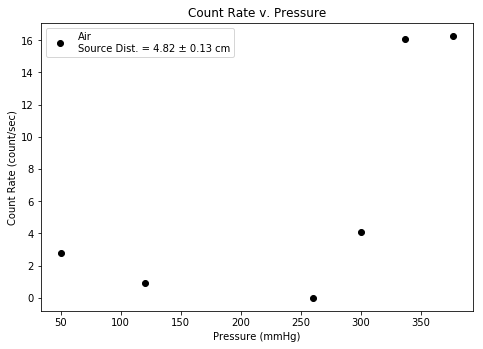

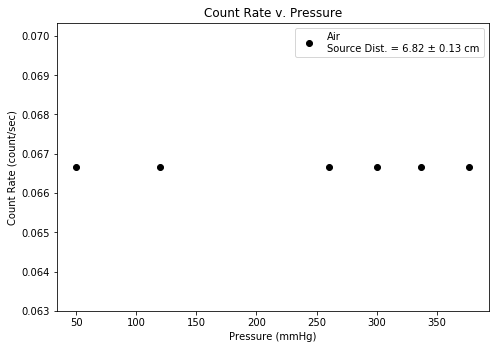

In [20]:
#!/usr/bin/env python3

def countvPressure(pressure, count, distance, xlabel, ylabel, title):
    
    import matplotlib.pyplot as plt
    
    count_rate = np.asarray(count)/30
    
    fig = plt.figure(num = 'Pressure %s' %pressure)
    ax = fig.add_axes([1,1,1,1])
    
    plt.plot(pressure, count_rate, 'ko')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    
    
    plt.legend(['Air\nSource Dist. = %s ± 0.13 cm'%distance])
    
    plt.show()
    
    fig.savefig('Figure %s'%pressure, bbox_inches = 'tight')
    
    return

countvPressure(close_pressure, close_count, 2.82, 'Pressure (mmHg)', 'Count Rate (count/sec)', 'Count Rate v. Pressure')
countvPressure(med_pressure, med_count, 4.82, 'Pressure (mmHg)', 'Count Rate (count/sec)', 'Count Rate v. Pressure')
countvPressure(far_pressure, far_count, 6.82, 'Pressure (mmHg)', 'Count Rate (count/sec)', 'Count Rate v. Pressure')



['data_9.4cm_50mmHg.mca', 'data_9.4cm_377mmHg.mca', 'data_9.4cm_337mmHg.mca', 'data_9.4cm_300mmHg.mca', 'data_9.4cm_280mmHg.mca', 'data_9.4cm_260mmHg.mca', 'data_9.4cm_220mmHg.mca', 'data_9.4cm_120mmHg.mca']


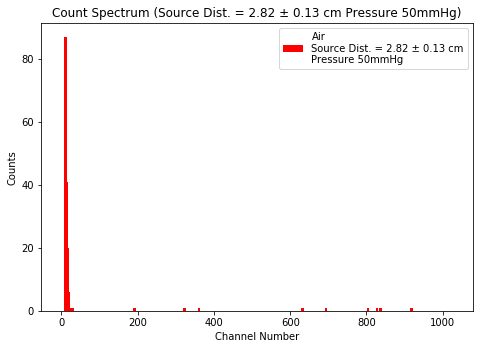

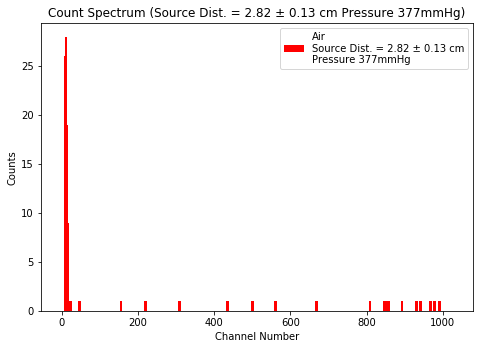

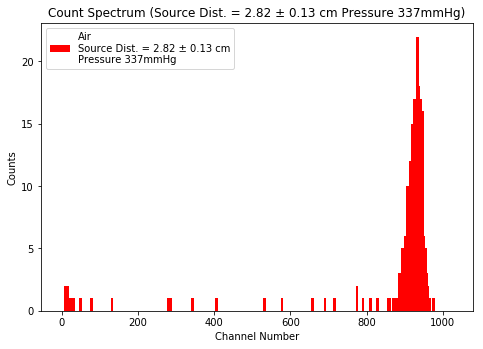

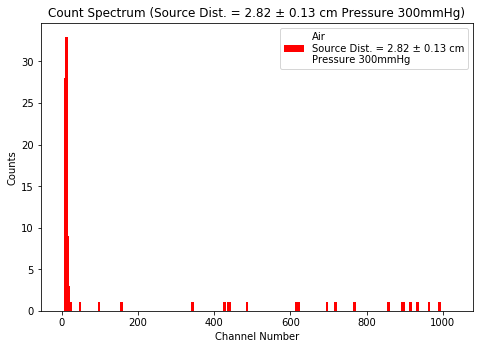

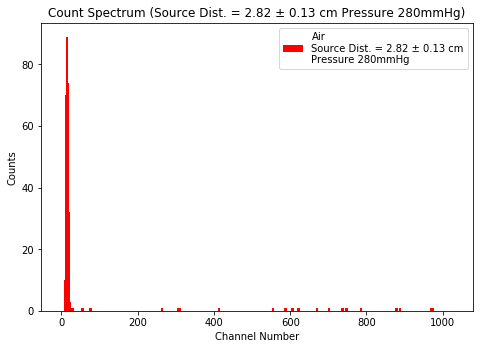

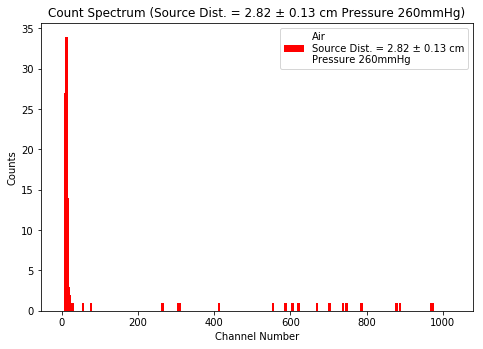

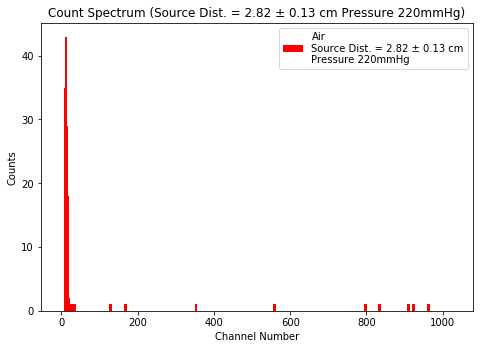

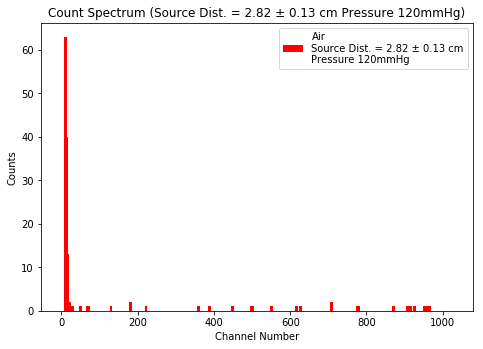

In [21]:
#!/usr/bin/env python3 

def pulse_height_spectra():
    import matplotlib.pyplot as plt
    import os
    import numpy as np
    import re 
    
    files_sorted = None
    for root, dirs, files in os.walk('height_spectra_air'):
        files_sorted = files
    
    files_sorted.sort(reverse = True)
    close_height_spectra = files_sorted[0:8]
    print(close_height_spectra)

    directory_path = os.path.abspath('height_spectra_air')
    
    for dataSet in close_height_spectra:
        title_regex = re.compile(r'\d{2,}mmHg')
        title_match = title_regex.search(dataSet)
        title_pressure = title_match.group()
        
        file_path = directory_path + '/' + dataSet
        
        
        
        file_name = open(file_path)
        raw_data = file_name.readlines()
        file_name.close
        
        signal = raw_data[12:len(raw_data) - 1]
        
        signal_array = np.asarray(signal, dtype = int)
        channel_array = np.linspace(1, 1024, 1024)
        
        fig = plt.figure(num = 'Pressure %s'%title_pressure)
        ax = fig.add_axes([1,1,1,1])
        
        plt.bar(channel_array, signal_array, width = 7.0, color = ['red'])
        plt.xlabel('Channel Number')
        plt.ylabel('Counts')
        plt.title('Count Spectrum (Source Dist. = 2.82 ± 0.13 cm Pressure %s)'%title_pressure)
        
        plt.legend(['Air\nSource Dist. = 2.82 ± 0.13 cm\nPressure %s'%title_pressure])
        
        
        plt.show()
        
        fig.savefig('pressure %s' %title_pressure, bbox_inches = 'tight')
        
    return 

pulse_height_spectra()